## Create a 2D grid

1. [geopandas create 2D grid polygons - Google Search](https://www.google.com/search?ei=FKOSW4GoOYaOmgX7z6nIDg&q=geopandas+create+2D+grid+polygons&oq=geopandas+create+2D+grid+polygons&gs_l=psy-ab.3...12002.12301.0.13280.2.2.0.0.0.0.121.237.0j2.2.0....0...1c.1.64.psy-ab..0.0.0....0.lNH15BerTPI)
* [python - Create a polygon grid using with Geopandas - Geographic Information Systems Stack Exchange](https://gis.stackexchange.com/questions/269243/create-a-polygon-grid-using-with-geopandas?rq=1)
* [Creating square grid polygon shapefile with Python? - Geographic Information Systems Stack Exchange](https://gis.stackexchange.com/questions/54119/creating-square-grid-polygon-shapefile-with-python)
* [Creating square grid polygon shapefile with Python? - Geographic Information Systems Stack Exchange](https://gis.stackexchange.com/questions/54119/creating-square-grid-polygon-shapefile-with-python/78030)
* [python - Shapefile to 2D grid as sparse matrix - Stack Overflow](https://stackoverflow.com/questions/36318145/shapefile-to-2d-grid-as-sparse-matrix)

In [130]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm
pd.set_option('max_colwidth',150)

In [ ]:
import gpd_lite_toolbox as glt

In [2]:
def make_grid(gdf, height, cut=True):
    from geopandas import GeoDataFrame
    """
    Return a grid, based on the shape of *gdf* and on a *height* value (in
    units of *gdf*). If cut=False, the grid will not be intersected with *gdf*
    (i.e it makes a grid on the bounding-box of *gdf*).
    Parameters
    ----------
    gdf: GeoDataFrame
        The collection of polygons to be covered by the grid.
    height: Integer
        The dimension (will be used as height and width) of the ceils to create,
        in units of *gdf*.
    cut: Boolean, default True
        Cut the grid to fit the shape of *gdf* (ceil partially covering it will
        be truncated). If False, the returned grid will fit the bounding box
        of *gdf*.
    Returns
    -------
    grid: GeoDataFrame
        A collection of polygons.
    """
    from math import ceil
    from shapely.ops import unary_union
    xmin, ymin = [i.min() for i in gdf.bounds.T.values[:2]]
    xmax, ymax = [i.max() for i in gdf.bounds.T.values[2:]]
    rows = ceil((ymax-ymin) / height)
    cols = ceil((xmax-xmin) / height)

    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                (x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                ))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height
    if cut:
        if all(gdf.eval(
            "geometry.type =='Polygon' or geometry.type =='MultiPolygon'")):
            res = GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry))
        else:
            res = GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry).convex_hull)
        res = res[res.geometry.type == 'Polygon']
        res.index = [i for i in range(len(res))]
        return GeoDataFrame(geometry=res)

    else:
        return GeoDataFrame(
            index=[i for i in range(len(res_geoms))],
            geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
            crs=gdf.crs
            )


In [3]:
def createRectangle_widthheight(xsize, ysize, width, height, srid=4326, **kwarg):
    ''' createRectangle widthheight : specify (x0,y0) and (width, height)'''
    xmin = float(xsize) - float(width) / 2.0
    xmax = float(xsize) + float(width) / 2.0
    ymin = float(ysize) - float(height) / 2.0
    ymax = float(ysize) + float(height) / 2.0
    return createRectangle_minmax(xmin, ymin, xmax, ymax, srid=srid, wkt=kwargs['wkt'])

def createRectangle_minmax(xmin, xmax, ymin, ymax, srid=4326, wkt=False):
    ''' createRectangle min-max : specify {x,y}{min,max}'''
    from shapely import geometry
    pointList = []
    pointList.append(geometry.Point(xmin, ymin))
    pointList.append(geometry.Point(xmin, ymax))
    pointList.append(geometry.Point(xmax, ymax))
    pointList.append(geometry.Point(xmax, ymin))
    pointList.append(pointList[0])
    Polygon = geometry.Polygon([[p.x, p.y] for p in pointList])
    if wkt:
        return 'SRID={};{}'.format(srid,Polygon.wkt)
    else:
        return Polygon

# print(createRectangle_widthheight(xsize=360,))

gdf = gpd.GeoDataFrame.from_dict({
    'name': ['bbox'],
    'polygon': createRectangle_minmax(xmin = 0, xmax= 360, ymin= -90, ymax= 90,wkt=False)},).set_geometry('polygon',inplace=False)
gdf

name                                          polygon
0  bbox  POLYGON ((0 -90, 0 90, 360 90, 360 -90, 0 -90))

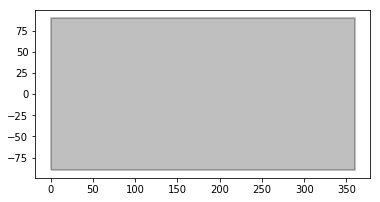

In [4]:
gdf.plot(color='black',alpha = 0.25, edgecolor='black', lw=2)

In [5]:
gridf = make_grid(gdf, 1, cut=False)
gridf['pid'] = gridf.index.tolist()
gridf['gid'] = 0
gridf['short_desc'] = 'grid_2D_0_360_-90_+90_1deg'
gridf['ctime'] = datetime.now()
gridf['mtime'] = gridf['ctime']

gridf = pd.DataFrame(gridf.copy())
# gridf.rename({'geoemtry':'poly'},axis='columns',inplace=True)
gridf.columns = ['poly', 'pid', 'gid', 'short_desc', 'ctime', 'mtime']
gridf['poly'] = gridf['poly'].apply(lambda x: 'SRID={s[srid]};{s[poly]}'.format(s={'poly':x.wkt,'srid':4326}))
gridf.shape

(64800, 6)

## DB manipulation

In [1]:
# import from parent directory : this is NOT NICE! but, wathever...
import sys
import os 
sys.path.append("..")

import dotenv_loader
db_connection_url = os.environ.get("DATABASE_URL")

In [ ]:
from sqlalchemy import create_engine
engine = create_engine(db_connection_url, echo=False,pool_size=20)
# this connects and raise error if not.
engine.connect()

In [6]:
%load_ext sql
%sql $db_connection_url

'Connected: damo_ma@mascscat'

In [7]:
import numpy as np
find_nearest = lambda array, value : (np.abs(array - value)).argmin()
wav_grid_2nm = np.arange(260,1052,2)
wavelength_idx = find_nearest(wav_grid_2nm,700)
print(wavelength_idx)

220


### DB : Insert cells

In [133]:
# declarative_base is used for the mapping local key <> pg columns name

from sqlalchemy import Table, Column, Integer, String, MetaData, DateTime
from geoalchemy2 import Geometry
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.dialects import postgresql

Base = declarative_base(metadata=MetaData())

class UserPolygon(Base):
    __tablename__ = 'userpolytest'

    pid = Column(Integer, primary_key=True)
    gid = Column(Integer)
    poly = Column(Geometry(geometry_type='POLYGON', srid=4326))
    short_desc = Column(String)
    ctime= Column(DateTime)
    mtime= Column(DateTime)
    mascspid = Column('photom_iof_sp_2nm', postgresql.ARRAY(Integer))
    
    def __repr__(self):
        return "<PolygonID='%s', GroupID='%s', CreationTime='%s', ModificationTime='%s'>" % (
            self.pid,self.gid,self.ctime,self.mtime)

In [123]:
Base.metadata.create_all(engine)

In [ ]:
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)

userpolygon_instance = [UserPolygon(**tbl) for tbl in gridf.rename({'geoemtry':'poly'},axis='columns').to_dict('records')]

session = Session()
session.add_all(userpolygon_instance)
session.commit()

### DB check MASCSdata 

In [ ]:
%sql SELECT m.pid FROM mascsdata AS m JOIN ( SELECT unnest(mascspid) as pid FROM userpolygon WHERE pid = 1546) p ON m.pid = p.pid

In [580]:
# sql = """SELECT m.pid, software_version, spacecraft_clock_start_count,
# along_track_footprint_size, packet_subseconds, partial_data,
# temperature_2, temp_2, spice_version_epoch,
# standard_data_product_id, spacecraft_clock_stop_count, saturation,
# start_time, across_track_footprint_size, temperature_1, low_vis_wavelength_uncertainty,
# incidence_angle, phase_angle,  anomalous_pixels,
# stop_time, dark_saturation, sc_time, uvvs_noise_spike,
# spectrum_met, product_id, spectrum_subseconds, spectrum_number,
# product_creation_time, emission_angle, site_id, int_count,
# uvvs_operating, detector_id, high_vis_wavelength_uncertainty,
# spectrum_utc_time, solar_distance, target_name,
# low_signal_level, mission_phase_name, product_version_id,
# dark_scan, data_quality_index, grating_temperature,
# photom_iof_sp_2nm, iof_sp_2nm
# FROM mascsdata AS m 
# JOIN ( SELECT unnest(mascspid) as pid FROM userpolygon WHERE pid = 1546) p 
#     ON m.pid = p.pid"""

# df = pd.read_sql(sql, engine,index_col='pid', coerce_float=True)

sql = """SELECT m.pid as pid, fov, software_version, spacecraft_clock_start_count,
along_track_footprint_size, packet_subseconds, partial_data,
temperature_2, temp_2, spice_version_epoch,
standard_data_product_id, spacecraft_clock_stop_count, saturation,
start_time, across_track_footprint_size, temperature_1, low_vis_wavelength_uncertainty,
incidence_angle, phase_angle,  anomalous_pixels,
stop_time, dark_saturation, sc_time, uvvs_noise_spike,
spectrum_met, product_id, spectrum_subseconds, spectrum_number,
product_creation_time, emission_angle, site_id, int_count,
uvvs_operating, detector_id, high_vis_wavelength_uncertainty,
spectrum_utc_time, solar_distance, target_name,
low_signal_level, mission_phase_name, product_version_id,
dark_scan, data_quality_index, grating_temperature,
photom_iof_sp_2nm, iof_sp_2nm
FROM mascsdata AS m 
JOIN ( SELECT unnest(mascspid) as mascspid FROM userpolygon WHERE pid = 1546) p 
    ON m.pid = p.mascspid"""

gdf = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='fov').set_index('pid')
wavelength = 700
wavelength_idx = find_nearest(wav_grid_2nm,wavelength)
gdf['refl'] = gdf['photom_iof_sp_2nm'].apply(lambda x: x[wavelength_idx])
userpolygondf = gpd.GeoDataFrame.from_postgis("SELECT * FROM userpolygon WHERE pid = 1546", engine, geom_col='poly').set_index('pid')


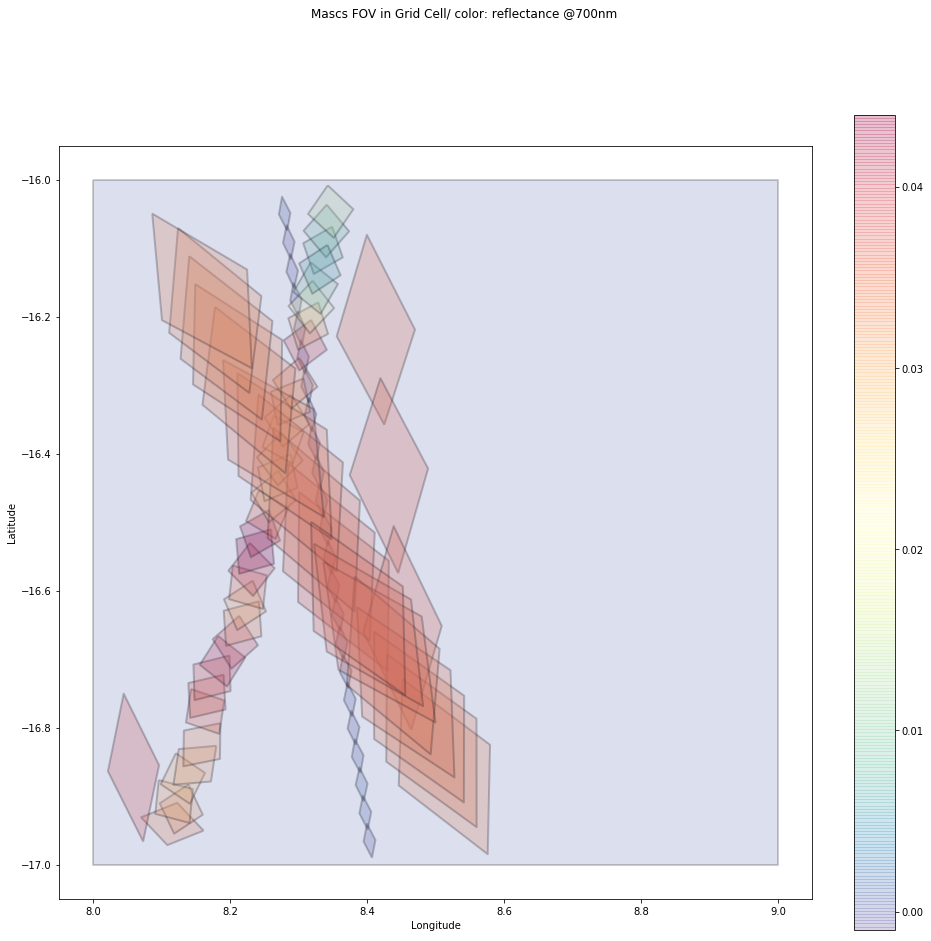

In [629]:
base = gdf.loc[gdf['refl'].dropna().index].plot(column='refl',alpha = 0.25,
                                                edgecolor='black', lw=2,
                                                figsize = [15,15], cmap=plt.cm.Spectral_r)
# base.set_axis_off()
base.set(xlabel='Longitude',ylabel='Latitude')
plt.gcf().suptitle('Mascs FOV in Grid Cell/ color: reflectance @700nm')
userpolygondf.plot(ax=base,alpha = 0.2, edgecolor='black', lw=2, 
                   color=plt.cm.Spectral_r(gdf['refl'].dropna().median()))
plt.colorbar(base.collections[0], ax=base,fraction=0.05)

In [65]:
df['color'] = df['iof_sp_2nm'].apply(lambda x : 'green' if all(v is None for v in x) else 'red')

In [164]:
csv_arr = np.array([8.8577512694354e+31, 3.44348451996452e+31, 1.73246080414006e+31, 4.79054559548046e+30, 0.00270102832098016, 0.00349848704054731, 0.00393885836643336, 0.0040383789425349, 0.00443049813673658, 0.00365759042637098, 0.00374882847420627, 0.00422359332931827, 0.00405255297945471, 0.00425432536060296, 0.00522439243538447, 0.00583764493483395, 0.00595037302910228, 0.0064511779407377, 0.00689860295739495, 0.00688721794928132, 0.0070012649159993, 0.00736116641279647, 0.00743111184815171, 0.00694954523979937, 0.00675898463467808, 0.00699562581118899, 0.00686874062975878, 0.0067609855333686, 0.00705623126908485, 0.00731871640980979, 0.00749686553804177, 0.00773055286416209, 0.00815817747619862, 0.00807441718261093, 0.0078008392780442, 0.00774634865943621, 0.00776153573500523, 0.00787055163061634, 0.00820909187720029, 0.00867174620603009, 0.0087397485019565, 0.00873041233171364, 0.00883966536121362, 0.00910509098264705, 0.00914245636589463, 0.00900855481148418, 0.00907696690425394, 0.00882107289829509, 0.00851591216352641, 0.00887241300559713, 0.0093356825735377, 0.00906358679362398, 0.00936397438002742, 0.00946444145555132, 0.00955167797093923, 0.00920473933085702, 0.00897955701859518, 0.00978224968864126, 0.0106038197171661, 0.00957207754063431, 0.00882524366938058, 0.00908789288342638, 0.0100149136491809, 0.0102456962345481, 0.0101362280400412, 0.0104205808809216, 0.0101861171561333, 0.0110442208463707, 0.011056745202571, 0.0108345611514104, 0.0104133528481079, 0.0102022734670138, 0.0103945231655326, 0.0109778697166654, 0.0110840611953928, 0.0112622281355879, 0.0114057821204147, 0.0112809734047644, 0.0112141458088183, 0.0113567827354502, 0.0114924969865766, 0.0112888245545633, 0.0111698946952657, 0.0110543397456077, 0.0110328556262007, 0.0116226782479114, 0.0123594142061614, 0.0121531834842271, 0.0119237562048284, 0.0117592878397644, 0.0118556107730391, 0.0117888274726769, 0.011721516223753, 0.0119105062242979, 0.0121124855131404, 0.0120427717058469, 0.0119850257767612, 0.0120494833697493, 0.0119910134234694, 0.0119680262538798, 0.0121599027733401, 0.0120825507364382, 0.0121096300851093, 0.0122603980405712, 0.0124581540645621, 0.0126107663362395, 0.0126686637405327, 0.0126813895501014, 0.0127245388760384, 0.0129422814865334, 0.0129302034091342, 0.0127971563202419, 0.0127789343316781, 0.0131588315720189, 0.0135519620786934, 0.0133578266789452, 0.0133728307408208, 0.0134181831513503, 0.0133708727171695, 0.0133584216796132, 0.0134200360652995, 0.0136191203929233, 0.0137529301879137, 0.0134825470235835, 0.0135508748496352, 0.0138637712464368, 0.0139376979731784, 0.013790081282336, 0.0139176571375195, 0.0144986983830649, 0.0145205552373442, 0.0144392237350726, 0.0142964372793782, 0.0144914568036476, 0.0147152946997899, 0.0145787469437218, 0.0144263883278807, 0.0146683111527008, 0.0146508576033521, 0.014675180717532, 0.0147963682676811, 0.0148676472259308, 0.0148178418629161, 0.0147828240004571, 0.0148331945107049, 0.0148839126496436, 0.0149300988548246, 0.014920361711725, 0.0149838164189119, 0.0151623648591129, 0.0153796025113343, 0.0154340507378738, 0.0154551721186184, 0.0153712771974455, 0.0155019530675134, 0.0156496821331523, 0.0157432006776336, 0.015727034450352, 0.015706026677648, 0.0156913676612039, 0.0156739366071783, 0.0156286290725729, 0.015541045062172, 0.0155165166668515, 0.0156560659109223, 0.0160261568182694, 0.0159646444728594, 0.0159652883541725, 0.0159915775381927, 0.0158983214138247, 0.0159156751486226, 0.0160347657103586, 0.0160770478644741, 0.0160783408907074, 0.016223386138958, 0.0162578944708373, 0.0162507914355275, 0.0163575770021399, 0.0165507227578818, 0.0166970541725245, 0.0165378215881961, 0.0164879056776597, 0.016663834415605, 0.0166842787817246, 0.0165574774824275, 0.0165380327918287, 0.0166276501254688, 0.0166334594575805, 0.0167465498443539, 0.0166856497811239, 0.0167434604722029, 0.0168492228131485, 0.0168923106786952, 0.0169176442054759, 0.016956904754242, 0.0169618675852455, 0.0167756354522947, 0.0168088304211499, 0.01742699272744, 0.0176652095342093, 0.0173588606850507, 0.0173411589949705, 0.0173993357822665, 0.0174434360824572, 0.0173453340594551, 0.0172909985147729, 0.0174559791756762, 0.0175868035885219, 0.0176914924316409, 0.0179527841747798, 0.018032178946102, 0.0180796131792323, 0.0182181075891249, 0.0181602060384607, 0.0180137734315068, 0.0178787814110992, 0.0177400058290157, 0.0177774903078993, 0.0176685402235958, 0.0175220379605597, 0.0174625792953521, 0.0174664087804371, 0.017356324124697, 0.0174113768912647, 0.0175678753709603, 0.0177317081258507, 0.0179506100500171, 0.0181086761509076, 0.0181309523118674, 0.0181676248792269, 0.0183759378752565, 0.0185145568650309, 0.0186482129998763, 0.0186946381398097, 0.0186190418595386, 0.0185758223946481, 0.0184745734919553, 0.0184086718607068, 0.0182759180516487, 0.0183600366357929, 0.0185653097978062, 0.0185334793380529, 0.018542104019945, 0.0184842648085459, 0.018591927004977, 0.0187720283289447, 0.0188774084603802, 0.0189282594064235, 0.0190699665103532, 0.0192858488284082, 0.0194594540635624, 0.0194324873169992, 0.0190905717954437, 0.0190982951181169, 0.018982722013913, 0.0188200440528856, 0.0187582874224404, 0.018737333188883, 0.0187821072072272, 0.0190858379252347, 0.0189965837814904, 0.0189172902430694, 0.0190706921327913, 0.0189664010719697, 0.0185981288928096, 0.0185832198607901, 0.0186865301166802, 0.0189093581391723, 0.0187262282197163, 0.0187567447316567, 0.0194024381355885, 0.0195979176157806, 0.0196511906946076, 0.0198936563695886, 0.0202336682933839, 0.0202584410008702, 0.0196201137343818, 0.0190302715950331, 0.0186268433350577, 0.0185180373599847, 0.0188767987268197, 0.0190756418196328, 0.0190699155824327, 0.0194337264834068, 0.0198132048660599, 0.0196684770668128, 0.0197002172118764, 0.0193965898749019, 0.0194607316034274, 0.0198725767840092, 0.0205518165743727, 0.021418310875385, 0.0212807228591288, 0.020535978497201, 0.0203976457027918, 0.0210301648942174, 0.0210315061263223, 0.0212938665137209, 0.0206177508018206, 0.0218623266464664, 0.0216788279700822, 0.0203871757137297, 0.0201929261735321, 0.0210225643264756, 0.0210265900164114, 0.0202480062840795, 0.0204680932614249, 0.0196668385791737, 0.0201811189098881, 0.020412233738597, 0.0208573221823954, 0.0210537576293523, 0.0210366829057104, 0.0217439272672122, 0.0212512201333602, 0.0207825160693718, 0.0212169975794618, 0.0219137684310579, 0.0217025600522446, 0.0210123787020752, 0.0204160616195734, 0.0201278708674733, 0.0209702306595793, 0.0213245283970714, 0.0212261079599656, 0.0211567540126713, 0.0213777210618627, 0.0213161062467893, 0.0212106340984513, 0.0216791541337424, 0.0199518976484318, 0.0191203688824673, 0.0197605139493985, 0.0200535187862919, 0.0202771263142548, 0.0195263459857958, 0.0197431551413231, 0.0192340181680448, 0.0194070361087688, 0.0187847881532409, 0.0187220083010824, 0.0194193584670004, 0.0203327424930528, 0.0202895197157967, 0.0210160955258563, 0.0232822858708228, 0.0247173049754616, 0.0227067436995154, 0.0210996212718416, 0.0188524367914282, 0.0165994996598657, 0.0185835360354915, 0.019418845718948, 0.0194303166185032, 0.0231573124687454, 0.0227205152953944, 0.023890039438845, 0.0226664369062183, 0.0209144788450706, 0.0206954639534683, 0.0206429847807573, 0.0207000331388616, 0.0215064592827296, 0.0191012084272378, 0.0180416787706268, 0.0189197913977317, 0.0180821658647284, 0.0169935551081249, 0.012649059391308, 0.0145806009527714, 0.0194333422880599, 0.0143072347252228, 0.0140718219404668, 0.0175063861630674, 0.0158892377577461, 0.0139597637511731, 0.012643962912716, 0.0178399662457204, 0.0131705176382566, 0.00308852075828598, -0.00356816612132478, -0.00153520070085776, -0.00172873015113197, 0.0070078541277863, 0.0156535053684571, -0.00407787077873115, 0.00242763575656386, -0.0121131934580362, -0.0120359794534794, -0.0140979457026343, -0.0118326843663701, -0.0076293393211339, 0.0133309339581828, 0.022439548910213, 0.061168517330936, 0.069020298254644])

np.nanmean(np.stack(df['iof_sp_2nm'].values, axis=0).astype(np.float),axis=0)[0:10], outdf_gdf.iloc[1546]['array'][0:10], csv_arr[0:10]

(array([  8.85775127e+31,   3.44348452e+31,   1.73246080e+31,
          4.79054560e+30,   2.70102832e-03,   3.49848704e-03,
          3.93885837e-03,   4.03837894e-03,   4.43049814e-03,
          3.65759043e-03]),
 array([-1.]),
 array([  8.85775127e+31,   3.44348452e+31,   1.73246080e+31,
          4.79054560e+30,   2.70102832e-03,   3.49848704e-03,
          3.93885837e-03,   4.03837894e-03,   4.43049814e-03,
          3.65759043e-03]))

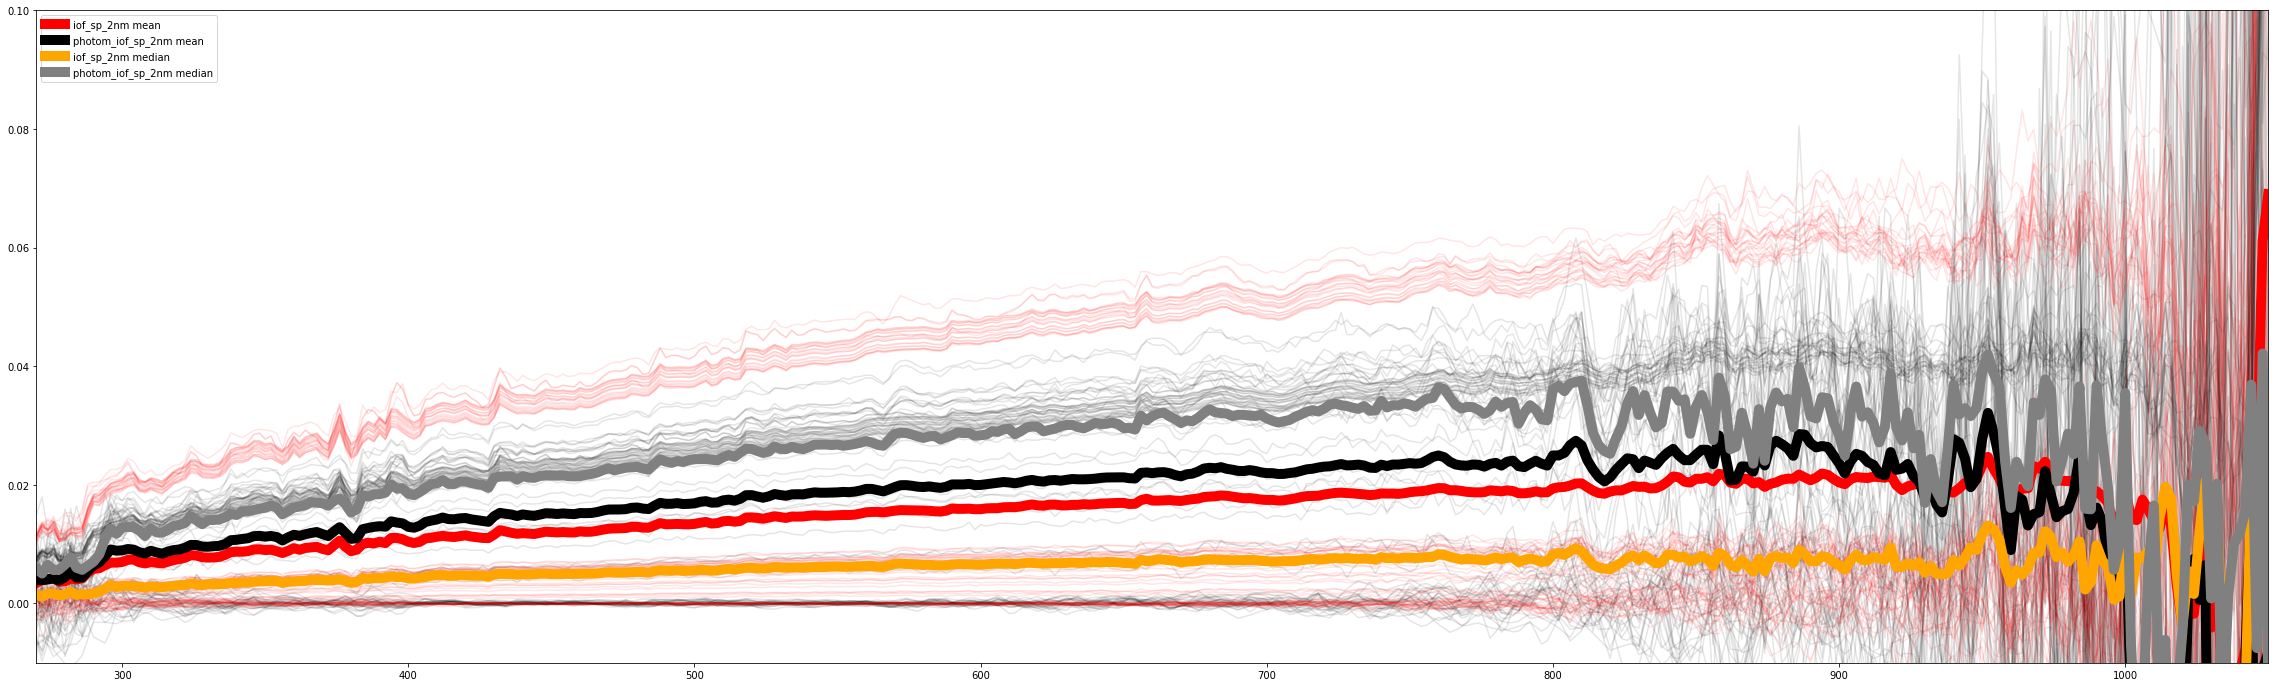

In [118]:
plt.figure(figsize=[40,12])
for index, row in df.iterrows():
    plt.plot(wav_grid_2nm,row['photom_iof_sp_2nm'],'black',alpha=0.1)
    plt.plot(wav_grid_2nm,row['iof_sp_2nm'],'red',alpha=0.1)
    
plt.plot(wav_grid_2nm,np.nanmean(np.stack(df['iof_sp_2nm'].values, axis=0).astype(np.float),axis=0),'red',lw=10, label='iof_sp_2nm mean')
plt.plot(wav_grid_2nm,np.nanmean(np.stack(df['photom_iof_sp_2nm'].values, axis=0).astype(np.float),axis=0),'black',lw=10,label='photom_iof_sp_2nm mean')

plt.plot(wav_grid_2nm,np.nanmedian(np.stack(df['iof_sp_2nm'].values, axis=0).astype(np.float),axis=0),'orange',lw=10, label='iof_sp_2nm median')
plt.plot(wav_grid_2nm,np.nanmedian(np.stack(df['photom_iof_sp_2nm'].values, axis=0).astype(np.float),axis=0),'gray',lw=10,label='photom_iof_sp_2nm median')


plt.xlim(270,1050);
plt.ylim(-0.01,0.1);
plt.legend();

### DB :  cells retrieval

In [547]:
sql = "SELECT * FROM userpolygon;"
gdf = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='poly',index_col='pid')

# dataframe
# df = pd.read_sql(sql, engine)
# df['mascspid_len'] = df['mascspid'].apply(lambda x: len(x) if x else 0)
# df['query'] = ''

In [65]:
gdf.sample(5).T

pid                                                                                                       5892   \
gid                                                                                                           0   
poly                                                         POLYGON ((32 -42, 33 -42, 33 -43, 32 -43, 32 -42))   
short_desc                                                                           grid_2D_0_360_-90_+90_1deg   
ctime                                                                                2018-09-10 11:14:11.333883   
mtime                                                                                2018-09-10 11:14:11.333883   
mascspid    [3273978, 3274082, 3274097, 3274113, 3274125, 3274153, 3274181, 4538139, 4538173, 4538200, 45382...   

pid                                                                                                       62133  \
gid                                                                                                           0   
poly                                                         POLYGON ((345 57, 346 57, 346 56, 345 56, 345 57))   
short_desc                                                                           grid_2D_0_360_-90_+90_1deg   
ctime                                                                                2018-09-10 11:14:11.333883   
mtime                                                                                2018-09-10 11:14:11.333883   
mascspid    [2914144, 2914171, 2914193, 2914209, 2914230, 3896636, 1854254, 2914059, 2914092, 2914119, 46559...   

pid                                                                                                       47183  \
gid                                                                                                           0   
poly                                                         POLYGON ((262 67, 263 67, 263 66, 262 66, 262 67))   
short_desc                                                                           grid_2D_0_360_-90_+90_1deg   
ctime                                                                                2018-09-10 11:14:11.333883   
mtime                                                                                2018-09-10 11:14:11.333883   
mascspid    [851434, 851461, 851484, 851505, 851523, 851553, 1979516, 1979534, 1979551, 1979569, 1979588, 25...   

pid                                                                                                       58243  \
gid                                                                                                           0   
poly                                                    POLYGON ((323 -13, 324 -13, 324 -14, 323 -14, 323 -13))   
short_desc                                                                           grid_2D_0_360_-90_+90_1deg   
ctime                                                                                2018-09-10 11:14:11.333883   
mtime                                                                                2018-09-10 11:14:11.333883   
mascspid    [838732, 838748, 838765, 838783, 838803, 838820, 838837, 838852, 838869, 838883, 838899, 838917,...   

pid                                                                                                       2664   
gid                                                                                                           0  
poly                                                         POLYGON ((14 -54, 15 -54, 15 -55, 14 -55, 14 -54))  
short_desc                                                                           grid_2D_0_360_-90_+90_1deg  
ctime                                                                                2018-09-10 11:14:11.333883  
mtime                                                                                2018-09-10 11:14:11.333883  
mascspid    [1334094, 1334111, 1334134, 1334148, 1903617, 1903637, 1903658, 1903682, 1903699

In [13]:
gdf['mascspid_len'] = gdf['mascspid'].apply(lambda x: len(x) if x else 1)
gdf['mascspid_lenlog'] = gdf['mascspid_len'].apply(np.log10)

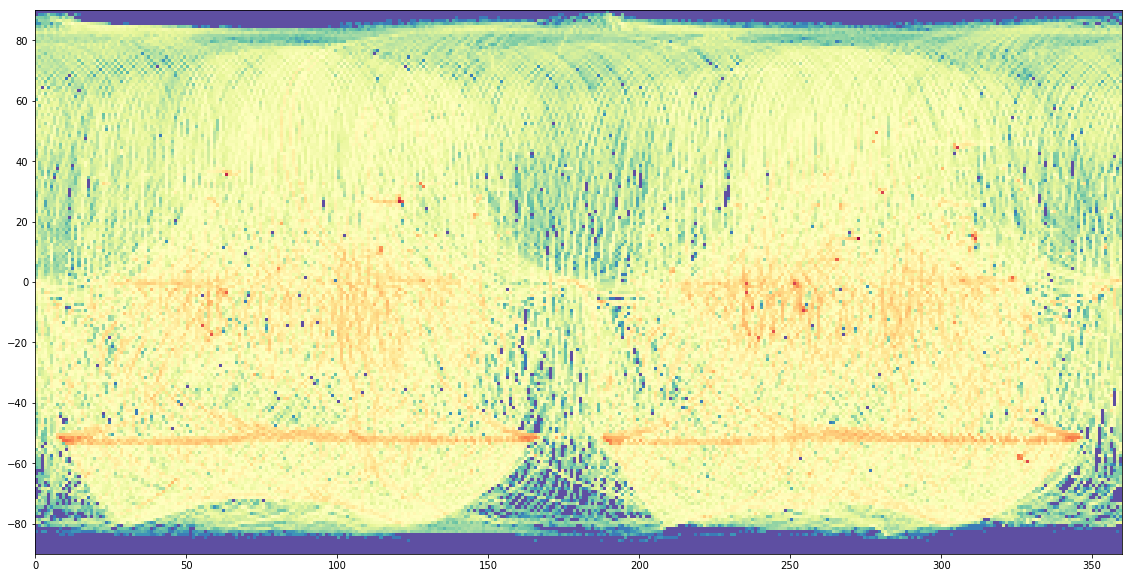

In [15]:
ax = gdf.plot(column='mascspid_lenlog',figsize=[20,10], cmap=plt.cm.Spectral_r)
ax.set(xlim=[0,360],ylim=[-90,90]);

In [ ]:
agg_function = 'st_median' # 'avg'
# agg_function = 'avg'
# arr_name= 'photom_iof_sp_2nm'
arr_name= 'iof_sp_2nm'

ext_sql_query= """SELECT p.pid ,(
    SELECT ARRAY (
        SELECT {}(elem)
        FROM ( 
            SELECT m.{} AS arr 
            FROM mascsdata AS m 
            WHERE m.pid = ANY(p.mascspid)
        ) t , unnest(t.arr) WITH ORDINALITY x(elem, rn)
        GROUP BY rn
        ORDER BY rn
    )
)
FROM userpolygon as p LIMIT 100 OFFSET 16000""".format(agg_function,arr_name)

df = pd.read_sql_query(ext_sql_query,engine, index_col='pid')

In [ ]:
plt.figure(figsize=[18,12])
for index, row in df.iterrows():
    plt.plot(wav_grid_2nm,row['array'])
plt.xlim(270,1050);
plt.ylim(0.00,0.1);

In [223]:
gdf.join(df)[outcolumns].shape

(64800, 2)

In [126]:
extensions = '.csv.bz2'
outfile = '{}_{}_{}{}'.format(gdf.short_desc.values[0],agg_function,arr_name,extensions)
outcolumns = ['poly', 'array']
# gpd.GeoDataFrame.to_file(gdf.join(df).loc[df.index,outcolumns], outfile+'.geojson', driver='GeoJSON')
gdf.join(df).loc[df.index,outcolumns].to_csv(outfile,compression='bz2')

NameError: name 'gdf' is not defined

In [534]:
import shapely.wkt

# outfile = 'grid_2D_0_360_-90_+90_1deg_avg_iof_sp_2nm'
# outfile = 'grid_2D_0_360_-90_+90_1deg_avg_photom_iof_sp_2nm'
# outfile = 'grid_2D_0_360_-90_+90_1deg_st_median_iof_sp_2nm'
outfile = 'grid_2D_0_360_-90_+90_1deg_st_median_photom_iof_sp_2nm'
# outfile = 'test.csv'

def numpy_array_converter(x):
    if x != '[]':
        g = lambda x: np.nan if x.strip() == 'None' else np.float(x)
        return np.array([g(x) for x in x[1:-1].split(',')])
    else:
        return np.nan

outdf = pd.read_csv(outfile+'.csv.bz2',
                    converters= {'poly':shapely.wkt.loads,'array':numpy_array_converter},
                    dtype = {'pid':int},
                    index_col='pid')

In [429]:
outdf['array_len'] = outdf['array'].apply(lambda x: np.nan if np.isnan(x).all() else x.size)
# outdf['array'].shape,outdf['array'].dropna().shape

In [346]:
crs = {'init': 'epsg:4326'}
outdf_gdf = gpd.GeoDataFrame(outdf, crs=crs, geometry='poly')

In [683]:
wavelength = 750
wavelength_idx = find_nearest(wav_grid_2nm,wavelength)
# print(wavelength_idx)
# outdf_gdf['refl'] = outdf_gdf['array'].apply(lambda x : x[wavelength_idx-10:wavelength_idx+10].mean())
outdf_gdf['refl'] = outdf_gdf['array'].apply(lambda x: np.nan if np.isnan(x).all() else np.nanmean(x[wavelength_idx-5:wavelength_idx+5]))

In [681]:
outdf_gdf.loc[(outdf_gdf['refl'] < 0.01) | (outdf_gdf['refl'] > 0.1),'refl']  = np.nan

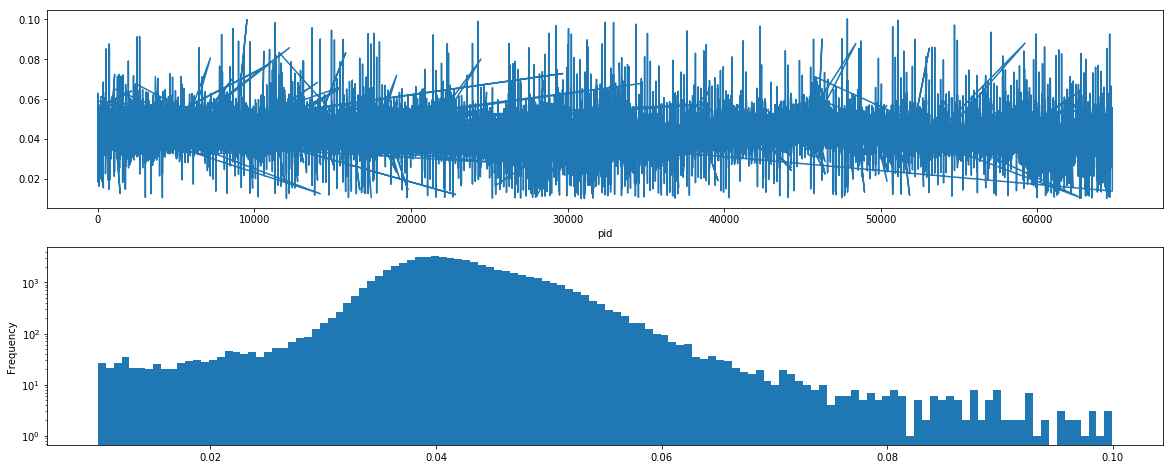

In [694]:
f, ax = plt.subplots(nrows=2,ncols=1, figsize=[30,8])
outdf_gdf.loc[(outdf_gdf['refl'] > 0.01) & (outdf_gdf['refl'] < 0.1),'refl'].plot(ax=ax[0])
outdf_gdf.loc[(outdf_gdf['refl'] > 0.01) & (outdf_gdf['refl'] < 0.1),'refl'].plot(ax=ax[1],kind='hist',bins=128,figsize=[20,8],log=True)

/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0
/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


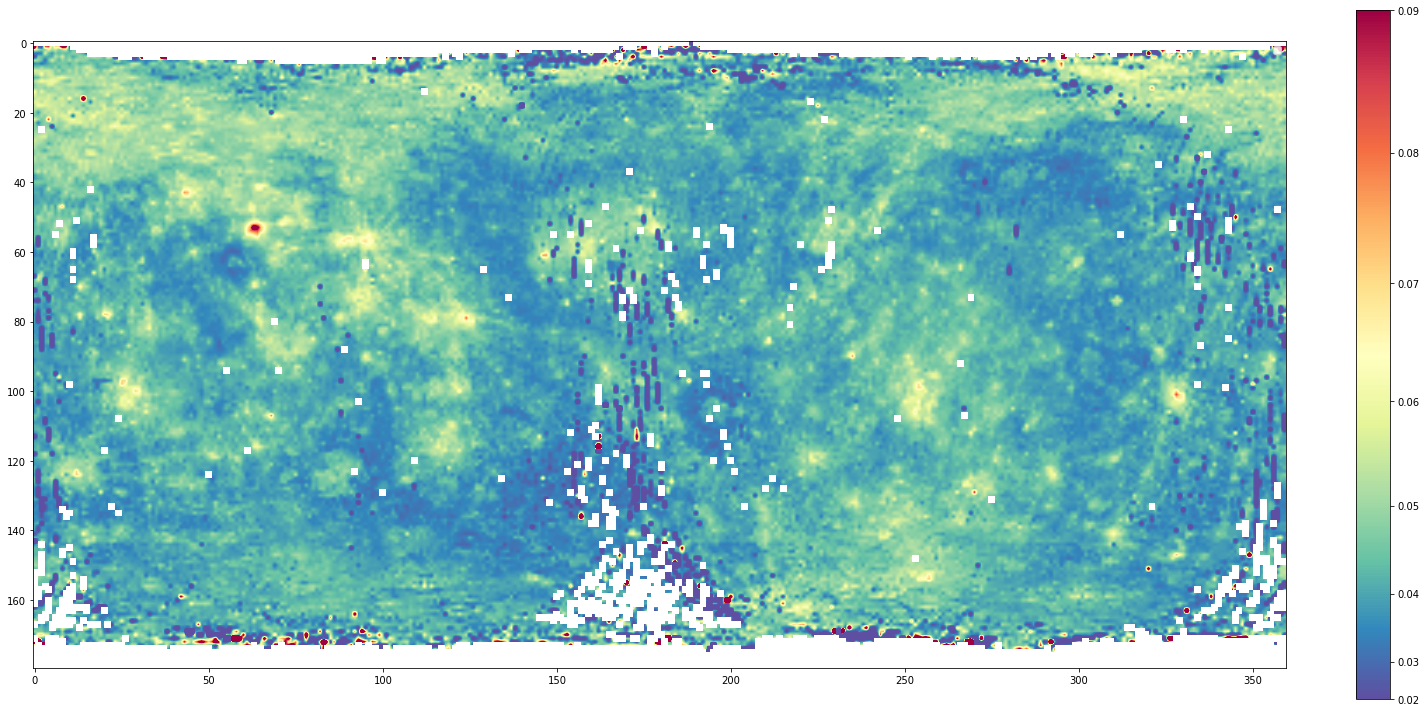

In [696]:
import copy
my_cmap = copy.copy(plt.cm.Spectral_r) # copy the default cmap
# my_cmap.set_over('r', 1.0)
# my_cmap.set_under('g', 1.0)
my_cmap.set_bad('black', 0.0)

plt.figure(figsize=[20,10])
plt.imshow(outdf_gdf.sort_index()['refl'].values.reshape(360,180).T,
           interpolation= 'bilinear',
           norm=matplotlib.colors.PowerNorm(1.5,vmin=0.02,vmax=0.09),
           cmap=my_cmap);
plt.colorbar(fraction=0.05)
plt.legend('grid : {} / color : nm'.format(outfile,wavelength))
plt.tight_layout()
plt.savefig(outfile,dpi=200)

/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


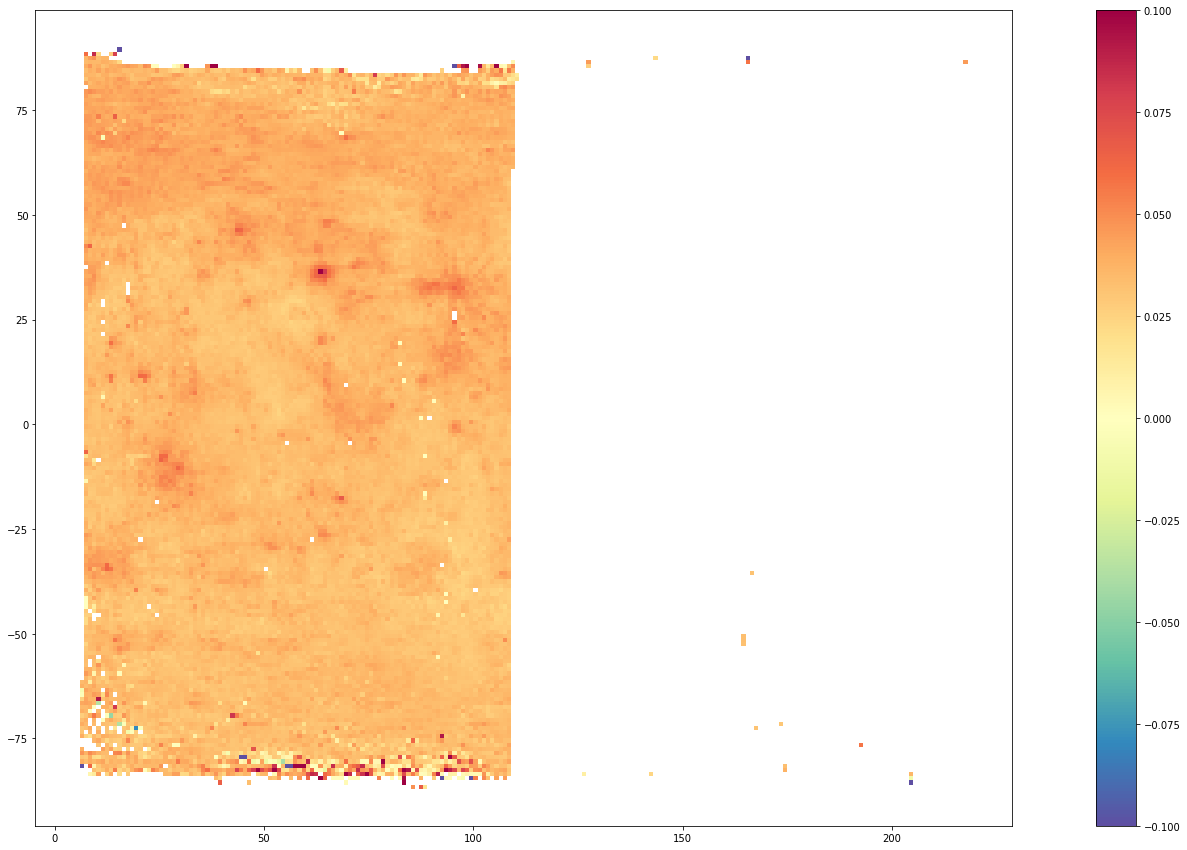

In [470]:
import copy
my_cmap = copy.copy(plt.cm.Spectral_r) # copy the default cmap
# my_cmap.set_over('r', 1.0)
# my_cmap.set_under('g', 1.0)
# my_cmap.set_bad('black', 1.0)

ax= outdf_gdf.head(outdf_gdf.size//15).plot(column='refl',edgecolor=None,figsize=[30,15],norm=matplotlib.colors.Normalize(vmin=0.01,vmax=0.1),cmap=my_cmap);
plt.colorbar(ax.collections[0], ax=ax)

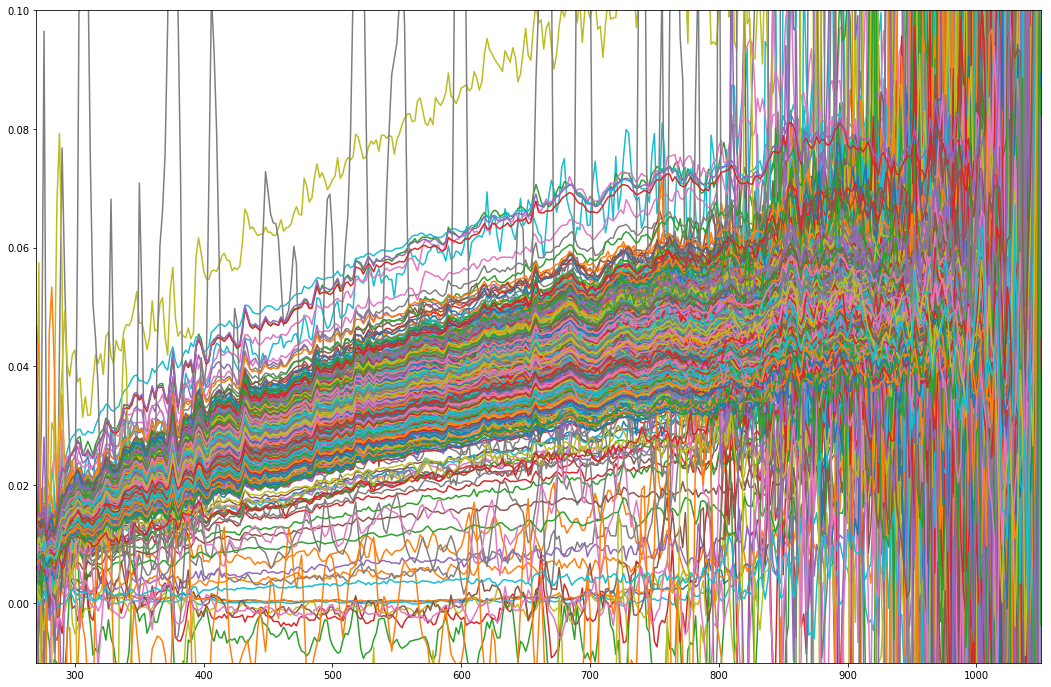

In [407]:
## outfile = 'grid_2D_0_360_-90_+90_1deg_st_median_photom_iof_sp_2nm.csv.bz2'
plt.figure(figsize=[18,12])
for index, row in outdf_gdf.head(1000).iterrows():
    plt.plot(wav_grid_2nm,row['array'])
plt.xlim(270,1050);
plt.ylim(-0.01,0.1);

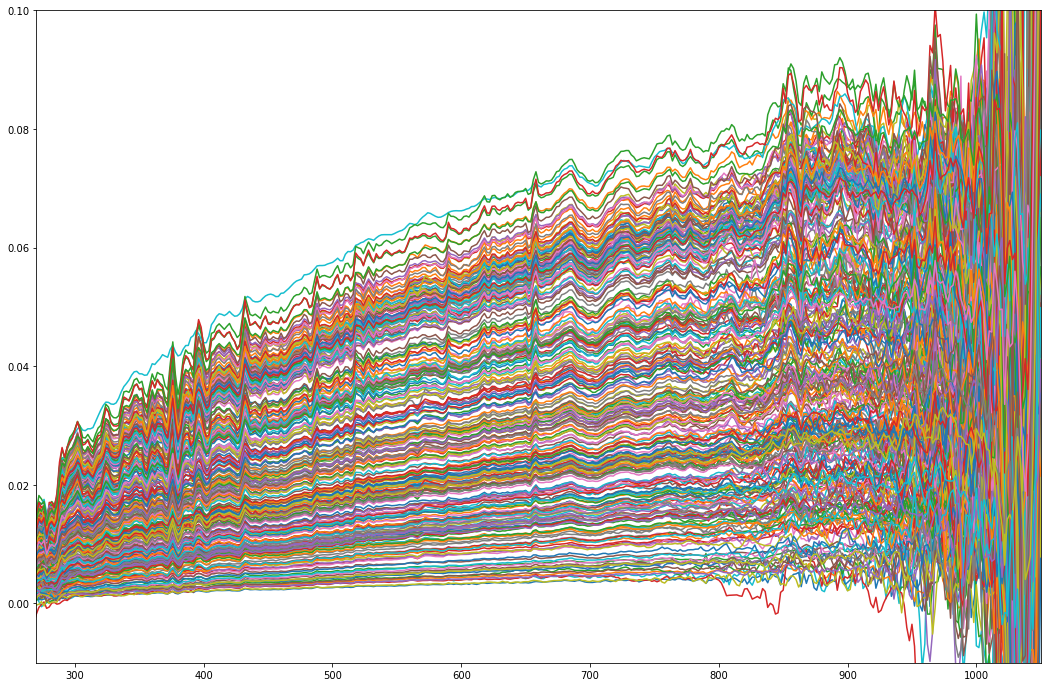

In [343]:
## outfile = 'grid_2D_0_360_-90_+90_1deg_avg_iof_sp_2nm.csv.bz2'
plt.figure(figsize=[18,12])
for index, row in outdf_gdf.head(290).iterrows():
    plt.plot(wav_grid_2nm,row['array'])
plt.xlim(270,1050);
plt.ylim(-0.01,0.1);

### DB :  multiple query per cell

In [26]:
agg_function = 'st_median' # 'avg'
agg_query = """SELECT ARRAY (
   SELECT {}(elem)
   FROM  ({}) t , unnest(t.arr) WITH ORDINALITY x(elem, rn)
   GROUP BY rn
   ORDER BY rn
   );"""

# this create duplicates in results, I guess the double FROM m,p without JOIN!
# query="""WITH p AS ( SELECT * from userpolytest) SELECT m.{} AS arr FROM mascsdata AS m,p WHERE m.pid = ANY(ARRAY[{}])"""

query="""SELECT m.{} AS arr FROM mascsdata AS m WHERE m.pid = ANY(ARRAY[{}])"""

query_single="""SELECT m.{} AS arr FROM mascsdata AS m WHERE m.pid = {}"""


arr_name= 'photom_iof_sp_2nm'
# arr_name= 'iof_sp_2nm'

print(agg_query.format(agg_function, query.format(arr_name, [1,2,3])))

SELECT ARRAY (
   SELECT st_median(elem)
   FROM  (SELECT m.photom_iof_sp_2nm AS arr FROM mascsdata AS m WHERE m.pid = ANY(ARRAY[[1, 2, 3]])) t , unnest(t.arr) WITH ORDINALITY x(elem, rn)
   GROUP BY rn
   ORDER BY rn
   );


In [28]:
# Try using .loc[row_indexer,col_indexer] = value instead
df['query'] = ''
df.loc[df['mascspid_len'] > 1,'query'] = df.loc[df['mascspid_len'] > 1, 'mascspid'].apply(lambda x: agg_query.format(agg_function,query.format(arr_name, x)) )

df.loc[df['mascspid_len'] == 1,'query'] = df.loc[df['mascspid_len'] == 1, 'mascspid'].apply(lambda x: query_single.format(arr_name, *x) )

In [29]:
print(df.loc[df['mascspid_len'] > 1,['query','mascspid_len','mascspid']].sort_values(by='mascspid_len').head(1)['query'].values[0])


SELECT ARRAY (
   SELECT st_median(elem)
   FROM  (SELECT m.photom_iof_sp_2nm AS arr FROM mascsdata AS m WHERE m.pid = ANY(ARRAY[[4459439, 4475140]])) t , unnest(t.arr) WITH ORDINALITY x(elem, rn)
   GROUP BY rn
   ORDER BY rn
   );


In [30]:
print(df.loc[df['mascspid_len'] == 1,['query','mascspid_len','mascspid']].head(1)['query'].values[0])

SELECT m.photom_iof_sp_2nm AS arr FROM mascsdata AS m WHERE m.pid = 3822748


In [106]:
from sqlalchemy import text

def get_result_file(engine, sql_raw_query):
    return {'pid':sql_raw_query['pid'],
             'array':engine.execute(text(sql_raw_query['query'])).fetchone()['array'] if sql_raw_query['query'] else None}

# get_result_file(engine,df.loc[0])

In [ ]:
spectra = []
for key,record in df.sample(100).iterrows():
    print(record['pid'],record['mascspid_len'])
    spectra.append(get_result_file(engine, record))